# 量的データ用（For quantitaive data）
[Methods]  
- Clustering methods : Kmeans, GMM, FSSEM, FSS-Kmeans    
- Allocation methods : random, proportional allocation, post stratification, optimal allocation

-------------
### ライブラリのインポート＆その他の設定（Importing Libraries & Other Settings）

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y
from sklearn.metrics import silhouette_score
from sklearn.linear_model import Lasso

# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# シード設定
# from lightning.pytorch import seed_everything
# seed_everything(8)

# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

--------
### 実験設定

In [2]:
THRESHOLD = 2  # 外れ値除外のための閾値

SAMPLE_SIZE = 100  # 標本サイズ
DATA_SIZE = 100000  # データサイズ(df2)
RANDOM_STATE = 0  # 乱数シード


# 最小、最大クラスタ数
K_MIN = 2
K_MAX = 10

-----------
### データの前処理（Data Preprocessing）

##### 外れ値を除去する関数

In [3]:
# 外れ値の除去
def remove_outliers_zscore(
    data: pd.DataFrame, metric: str, threshold: float = 2
) -> pd.DataFrame:
    z_scores = np.abs(stats.zscore(data[metric]))
    data = data[(z_scores < threshold)]
    return data

##### メルカリデータ（df1：全部, df2：一部）

In [4]:
# df1(all the data)
df1 = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\aug_first_cpn_data_for_ab_test_sensibility_tsukuba.csv"
)
obj1 = "GMV"
features_list1 = [
    "hist_4_day_buy_num",
    "hist_4_day_gmv",
    "his_4_day_is_buy",
    "hist_30_day_buy_days",
    "hist_30_day_buy_num",
    "hist_30_day_gmv",
    "hist_30_day_buy_recency",
    "hist_30_day_pay_days",
    "hist_30_day_atpu",
    "hist_30_day_gpv",
    "hist_30_day_pay_recency",
    "hist_30_day_list_days",
    "hist_30_day_list_num",
    "hist_30_day_list_recency",
    "hist_30_day_like_count",
    "hist_30_day_like_count_not_deleted",
    "hist_30_day_like_recency",
]

# df2(subset of the data)
df2 = df1.iloc[:DATA_SIZE]
obj2 = obj1
features_list2 = features_list1

##### 外れ値除去と標準化

In [5]:
df = df2  # choose from (df1, df2)
obj = obj2  # choose from (obj1, obj2)
features_list = features_list2  # choose from (features_list1, features_list2)

# 外れ値除去
df = remove_outliers_zscore(data=df, metric=obj, threshold=THRESHOLD)

# 標準化
X = df[features_list]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)
X_scaled = pd.DataFrame(scaled_features, columns=features_list)

# 目的変数
y = df[obj]

# 行を詰める
df = df.reset_index(drop=True)

print("外れ値除外前のデータ数:", DATA_SIZE)
print("外れ値除外後のデータ数:", len(df))

外れ値除外前のデータ数: 100000
外れ値除外後のデータ数: 99082


-------------
### Xmeans で確認

##### Xmeans

In [6]:
def compute_bic(X, kmeans):
    labels = kmeans.labels_
    clusters = kmeans.cluster_centers_
    n_clusters = len(clusters)
    n = len(X)
    m = X.shape[1]
    variance = np.sum(
        [
            np.linalg.norm(X[labels == i] - clusters[i], axis=1).sum()
            for i in range(n_clusters)
        ]
    )
    bic = np.log(n) * n_clusters * m + n * np.log(variance / n)
    return bic


def xmeans(X, k_min=2, k_max=10):
    kmeans = KMeans(n_clusters=k_min, random_state=RANDOM_STATE)
    kmeans.fit(X)
    best_bic = compute_bic(X, kmeans)
    best_k = k_min
    score_dict = {}
    score_dict[k_min] = best_bic
    for k in range(k_min + 1, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        kmeans.fit(X)
        current_bic = compute_bic(X, kmeans)
        score_dict[k] = current_bic
        if current_bic < best_bic:
            best_bic = current_bic
            best_k = k
    return best_k, score_dict

##### クラスタリング結果

n_clusters chosen in Xmeans: 10


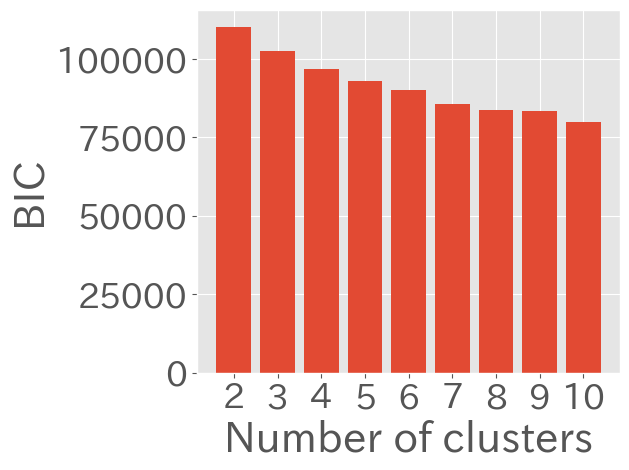

In [7]:
best_k, score_dict = xmeans(X_scaled, k_min=K_MIN, k_max=K_MAX)
print("n_clusters chosen in Xmeans:", best_k)

x = []
for k in score_dict.keys():
    x.append(str(k))
y = [score for score in score_dict.values()]
bars = plt.bar(x, y)
plt.ylabel("BIC", fontsize=30)
plt.xlabel("Number of clusters", fontsize=30)
plt.tick_params(axis="both", which="major", labelsize=25)
plt.tight_layout()
plt.show()


-----------------------------
### シルエット係数

In [8]:
def silhouette(X, k_min=2, k_max=10):
    kmeans = KMeans(n_clusters=k_min, random_state=RANDOM_STATE)
    kmeans.fit(X)
    labels = kmeans.predict(X)
    best_score = silhouette_score(X, labels)
    score_dict = {}
    score_dict[k_min] = best_score
    best_k = k_min
    for k in range(k_min + 1, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        kmeans.fit(X)
        labels = kmeans.predict(X)
        current_score = silhouette_score(X, labels)
        score_dict[k] = current_score
        if current_score > best_score:
            best_score = current_score
            best_k = k
    return best_k, score_dict


##### 結果

n_clusters chosen in Xmeans: 2


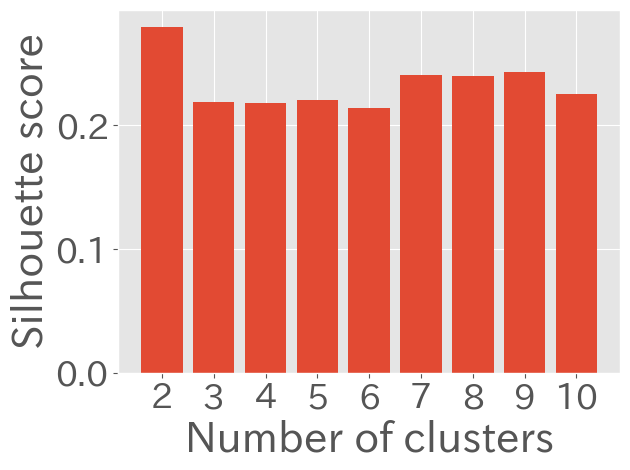

In [9]:
best_k, score_dict = silhouette(X_scaled, k_min=K_MIN, k_max=K_MAX)
print("n_clusters chosen in Xmeans:", best_k)

x = []
for k in score_dict.keys():
    x.append(str(k))
y = [score for score in score_dict.values()]
bars = plt.bar(x, y)
plt.ylabel("Silhouette score", fontsize=30)
plt.xlabel("Number of clusters", fontsize=30)
plt.tick_params(axis="both", which="major", labelsize=25)
plt.tight_layout()
plt.show()


In [10]:
print(score_dict)

{2: 0.2792517590872323, 3: 0.2188797091200716, 4: 0.21799183344841971, 5: 0.22032629012328978, 6: 0.21431697766237381, 7: 0.24073160505271374, 8: 0.24025403663770717, 9: 0.24299605849082562, 10: 0.22507601320477036}
